In [1]:
from pyspark.sql import SparkSession
from pyspark.sql import functions as F
from pyspark.ml.recommendation import ALS
spark = SparkSession.builder.appName('mov_ratings').getOrCreate()

/home/lplab/anaconda3/lib/python3.7/site-packages/pyspark/context.py:317: FutureWarning: Python 3.7 support is deprecated in Spark 3.4.
  warnings.warn("Python 3.7 support is deprecated in Spark 3.4.", FutureWarning)


# Import Data

In [10]:
ratings = spark.read.option("header","true").option("inferSchema","true").csv("ratings.csv").select("Userid","Movieid","Rating","Timestamp").cache()
ratings.show(5)
ratings.printSchema()

movies = spark.read.option("header","true").option("inferSchema","true").csv("movies.csv").select("movieid","title","genres").cache()
movies.show(5)
movies.printSchema()

# Joining ratings and movies DataFrame on MovieID
joined_df = ratings.join(movies, ratings.Movieid == movies.movieid, 'inner')

# Selecting UserID and Movie Title
result = joined_df.select("Userid", "title")

# Displaying the result
print("\n\n\nUser ID with Movie Title")
result.show(5)


+------+-------+------+---------+
|Userid|Movieid|Rating|Timestamp|
+------+-------+------+---------+
|     1|      1|   4.0|964982703|
|     1|      3|   4.0|964981247|
|     1|      6|   4.0|964982224|
|     1|     47|   5.0|964983815|
|     1|     50|   5.0|964982931|
+------+-------+------+---------+
only showing top 5 rows

root
 |-- Userid: integer (nullable = true)
 |-- Movieid: integer (nullable = true)
 |-- Rating: double (nullable = true)
 |-- Timestamp: integer (nullable = true)

+-------+--------------------+--------------------+
|movieid|               title|              genres|
+-------+--------------------+--------------------+
|      1|    Toy Story (1995)|Adventure|Animati...|
|      2|      Jumanji (1995)|Adventure|Childre...|
|      3|Grumpier Old Men ...|      Comedy|Romance|
|      4|Waiting to Exhale...|Comedy|Drama|Romance|
|      5|Father of the Bri...|              Comedy|
+-------+--------------------+--------------------+
only showing top 5 rows

root
 |-- m

# ALS ALgo

In [3]:
from pyspark.ml.recommendation import ALS
from pyspark.ml.evaluation import RegressionEvaluator

training_data,validation_data = ratings.randomSplit([8.0,2.0])

als = ALS(userCol="Userid",itemCol="Movieid",ratingCol="Rating",rank=10,maxIter=5,regParam=0.01,coldStartStrategy="drop")
evaluator = RegressionEvaluator(metricName="rmse",labelCol="Rating",predictionCol="prediction")
 
model = als.fit(training_data)
predictions=model.transform(validation_data)
predictions.show(15,False)

rmse = evaluator.evaluate(predictions)
print(f"Root Mean Squared Error (RMSE) = {rmse}")

# Userid, title and genre
df_joined = ratings.join(movies, ratings["Movieid"] == movies["movieid"], "inner").select(ratings["Userid"], ratings["Movieid"], ratings["Rating"], ratings["Timestamp"], movies["title"], movies["genres"])
df_joined.select('Userid','title','genres').show()


+------+-------+------+----------+----------+
|Userid|Movieid|Rating|Timestamp |prediction|
+------+-------+------+----------+----------+
|148   |1197   |3.0   |1482548478|3.9910226 |
|148   |6377   |3.0   |1482548514|3.975573  |
|148   |40629  |5.0   |1482548578|3.403437  |
|148   |44191  |4.0   |1482550089|2.9489496 |
|148   |54001  |4.0   |1482548674|4.5466785 |
|148   |69844  |4.0   |1482548500|4.372362  |
|148   |72998  |4.0   |1482548525|3.082027  |
|148   |88125  |4.0   |1482548673|4.9165883 |
|148   |98491  |5.0   |1482548665|3.6336029 |
|148   |116797 |4.5   |1482550073|3.773145  |
|148   |122920 |3.5   |1482548707|3.4197938 |
|463   |780    |3.5   |1145460355|4.078616  |
|463   |1088   |3.5   |1145460096|1.345397  |
|463   |2028   |4.5   |1145460281|4.66354   |
|463   |5952   |5.0   |1145460278|3.8385994 |
+------+-------+------+----------+----------+
only showing top 15 rows

Root Mean Squared Error (RMSE) = 1.0835930473838529
+------+--------------------+-------------------

# Kmeans

In [19]:
from pyspark.sql import SparkSession
from pyspark.ml.feature import VectorAssembler
from pyspark.ml.clustering import KMeans
from pyspark.ml.evaluation import ClusteringEvaluator


# Load data
ratings = spark.read.csv("ratings.csv", header=True, inferSchema=True)
movies = spark.read.csv("movies.csv", header=True, inferSchema=True)

# Join ratings and movies data
joined_data = ratings.join(movies, ratings["Movieid"] == movies["movieid"], "inner").select(ratings["Userid"], ratings["Movieid"], ratings["Rating"], movies["title"], movies["genres"])

# Prepare features for k-means clustering
vectorAssembler = VectorAssembler(inputCols=["Rating"], outputCol="features")
cluster_data = vectorAssembler.transform(joined_data)

# Scale features
from pyspark.ml.feature import StandardScaler
scaler = StandardScaler(inputCol="features", outputCol="scaledFeatures", withStd=True, withMean=False)
scalerModel = scaler.fit(cluster_data)
cluster_data = scalerModel.transform(cluster_data)

# Trains a k-means mode
kmeans = KMeans().setK(7)
model = kmeans.fit(cluster_data)

# Make predictions
predictions = model.transform(cluster_data)

# Evaluate clustering by computing Silhouette score
evaluator = ClusteringEvaluator()
silhouette = evaluator.evaluate(predictions)
print("Silhouette with squared euclidean distance = " + str(silhouette))

# Shows the result
print("Cluster Centers: ")
centers = model.clusterCenters()
for center in centers:
    print(center)

# Show clustered data
predictions.select('title', 'Rating', 'prediction').show()


Silhouette with squared euclidean distance = 0.9067041671304923
Cluster Centers: 
[3.5]
[4.80353368]
[1.03524782]
[2.5]
[4.]
[3.]
[2.]
+--------------------+------+----------+
|               title|Rating|prediction|
+--------------------+------+----------+
|    Toy Story (1995)|   4.0|         4|
|Grumpier Old Men ...|   4.0|         4|
|         Heat (1995)|   4.0|         4|
|Seven (a.k.a. Se7...|   5.0|         1|
|Usual Suspects, T...|   5.0|         1|
|From Dusk Till Da...|   3.0|         5|
|Bottle Rocket (1996)|   5.0|         1|
|   Braveheart (1995)|   4.0|         4|
|      Rob Roy (1995)|   5.0|         1|
|Canadian Bacon (1...|   5.0|         1|
|    Desperado (1995)|   5.0|         1|
|Billy Madison (1995)|   5.0|         1|
|       Clerks (1994)|   3.0|         5|
|Dumb & Dumber (Du...|   5.0|         1|
|      Ed Wood (1994)|   4.0|         4|
|Star Wars: Episod...|   5.0|         1|
| Pulp Fiction (1994)|   3.0|         5|
|     Stargate (1994)|   3.0|         5|
|   

# D ALS to each Cluster and RMSE of each

+--------------------+------+----------+
|               title|Rating|prediction|
+--------------------+------+----------+
|    Toy Story (1995)|   4.0|         6|
|Grumpier Old Men ...|   4.0|         6|
|         Heat (1995)|   4.0|         6|
|Seven (a.k.a. Se7...|   5.0|         1|
|Usual Suspects, T...|   5.0|         1|
|From Dusk Till Da...|   3.0|         5|
|Bottle Rocket (1996)|   5.0|         1|
|   Braveheart (1995)|   4.0|         6|
|      Rob Roy (1995)|   5.0|         1|
|Canadian Bacon (1...|   5.0|         1|
|    Desperado (1995)|   5.0|         1|
|Billy Madison (1995)|   5.0|         1|
|       Clerks (1994)|   3.0|         5|
|Dumb & Dumber (Du...|   5.0|         1|
|      Ed Wood (1994)|   4.0|         6|
|Star Wars: Episod...|   5.0|         1|
| Pulp Fiction (1994)|   3.0|         5|
|     Stargate (1994)|   3.0|         5|
|    Tommy Boy (1995)|   5.0|         1|
|Clear and Present...|   4.0|         6|
+--------------------+------+----------+
only showing top

RMSE for Cluster 0: 0.17824907257302217
+------+-------+------+----------+
|Userid|Movieid|Rating|prediction|
+------+-------+------+----------+
|    18|   1580|   3.5| 3.5339684|
|    18|  32460|   3.5| 3.4169881|
|    18|  44022|   3.5| 3.6394875|
|    20|   4519|   3.5|  3.426205|
|    21|  44022|   3.5|  3.626428|
|    64|   1580|   3.5|  3.693998|
|    64|   3175|   3.5| 3.5100236|
|    68|   1088|   3.5| 3.2977843|
|    68|  44022|   3.5|   3.52209|
|    73|  68135|   3.5| 3.4953501|
|    91|   1580|   3.5| 3.3784928|
|    91|   3175|   3.5|  3.427786|
|    91|   6620|   3.5|  3.397018|
|   111|   3175|   3.5|  3.370983|
|   119|  44022|   3.5| 3.5712001|
|   125| 160563|   3.5| 3.4729035|
|   137|   1580|   3.5| 3.3874807|
|   138|   1959|   3.5|  3.498087|
|   141|   1580|   3.5|   3.57825|
|   144|   1580|   3.5| 3.1496952|
+------+-------+------+----------+
only showing top 20 rows



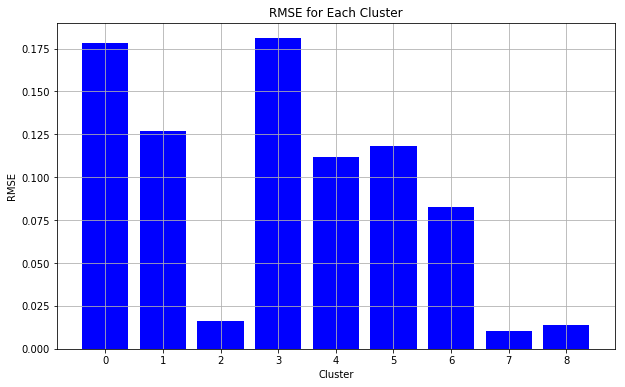

In [20]:
from pyspark.sql import SparkSession
from pyspark.ml.feature import VectorAssembler
from pyspark.ml.clustering import KMeans
from pyspark.ml.evaluation import ClusteringEvaluator
from pyspark.ml.recommendation import ALS
from pyspark.sql.functions import col, sqrt
from pyspark.sql import functions as F
import matplotlib.pyplot as plt

# Initialize Spark session
spark = SparkSession.builder \
    .appName("KMeans with ALS") \
    .getOrCreate()

# Load data
ratings = spark.read.csv("ratings.csv", header=True, inferSchema=True)
movies = spark.read.csv("movies.csv", header=True, inferSchema=True)

# Join ratings and movies data
joined_data = ratings.join(movies, ratings["Movieid"] == movies["movieid"], "inner").select(ratings["Userid"], ratings["Movieid"], ratings["Rating"], movies["title"], movies["genres"])

# Prepare features for k-means clustering
vectorAssembler = VectorAssembler(inputCols=["Rating"], outputCol="features")
cluster_data = vectorAssembler.transform(joined_data)

# Scale features
from pyspark.ml.feature import StandardScaler
scaler = StandardScaler(inputCol="features", outputCol="scaledFeatures", withStd=True, withMean=False)
scalerModel = scaler.fit(cluster_data)
cluster_data = scalerModel.transform(cluster_data)

# Train a k-means model
kmeans = KMeans().setK(9)
model = kmeans.fit(cluster_data)

# Make predictions
predictions = model.transform(cluster_data)

# Show clustered data
predictions.select('title', 'Rating', 'prediction').show()

# Group data by cluster prediction
grouped_data = predictions.groupBy("prediction").agg({"Userid": "count"}).withColumnRenamed("count(Userid)", "count")

# Lists to store cluster and RMSE values
clusters = []
rmse_values = []

# ALS for each cluster
for row in grouped_data.collect():
    cluster = row["prediction"]
    print(f"\nALS for Cluster {cluster}:")
    cluster_ratings = predictions.filter(predictions["prediction"] == cluster).select("Userid", "Movieid", "Rating")
    als = ALS(maxIter=5, regParam=0.01, userCol="Userid", itemCol="Movieid", ratingCol="Rating", coldStartStrategy="drop")
    als_model = als.fit(cluster_ratings)
    
    # Make predictions
    als_predictions = als_model.transform(cluster_ratings)
    
    # Calculate RMSE
    rmse = als_model.transform(cluster_ratings).select(F.sqrt(F.mean(F.pow(col("Rating") - col("prediction"), 2))).alias('rmse')).collect()[0]['rmse']
    print(f"RMSE for Cluster {cluster}: {rmse}")
    
    recommendations = als_predictions.filter(col("prediction") != col("Rating")).select("Userid", "Movieid", "Rating", "prediction")
    recommendations.show()
    # Append cluster and RMSE values to lists
    clusters.append(cluster)
    rmse_values.append(rmse)

# Plot the RMSE values for each cluster
plt.figure(figsize=(10, 6))
plt.bar(clusters, rmse_values, color='blue')
plt.xlabel('Cluster')
plt.ylabel('RMSE')
plt.title('RMSE for Each Cluster')
plt.xticks(clusters)
plt.grid(True)
plt.show()


# E

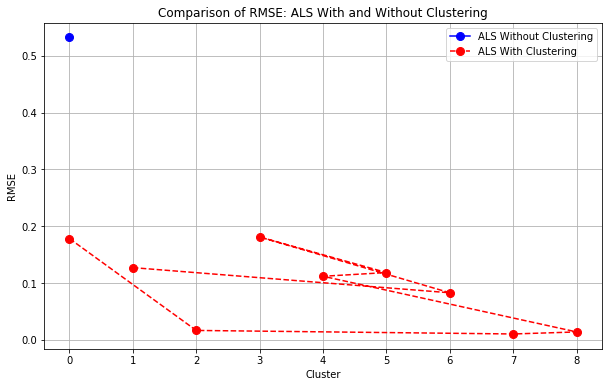

In [21]:
from pyspark.sql import SparkSession
from pyspark.ml.recommendation import ALS
from pyspark.sql.functions import col, sqrt
from pyspark.sql import functions as F
import matplotlib.pyplot as plt

# Initialize Spark session
spark = SparkSession.builder \
    .appName("ALS Comparison") \
    .getOrCreate()

# Load data
ratings = spark.read.csv("ratings.csv", header=True, inferSchema=True)
movies = spark.read.csv("movies.csv", header=True, inferSchema=True)

# Join ratings and movies data
joined_data = ratings.join(movies, ratings["Movieid"] == movies["movieid"], "inner").select(ratings["Userid"], ratings["Movieid"], ratings["Rating"], movies["title"], movies["genres"])

# Prepare features for ALS without clustering
als_data = joined_data.select("Userid", "Movieid", "Rating")

# ALS without clustering
als = ALS(maxIter=5, regParam=0.01, userCol="Userid", itemCol="Movieid", ratingCol="Rating", coldStartStrategy="drop")
als_model = als.fit(als_data)

# Make predictions
als_predictions = als_model.transform(als_data)

# Calculate RMSE for ALS without clustering
rmse_als = als_model.transform(als_data).select(F.sqrt(F.mean(F.pow(col("Rating") - col("prediction"), 2))).alias('rmse')).collect()[0]['rmse']

# Lists to store cluster and RMSE values
clusters = []
rmse_values_als_with_clustering = []

# Prepare features for k-means clustering
from pyspark.ml.feature import VectorAssembler
vectorAssembler = VectorAssembler(inputCols=["Rating"], outputCol="features")
cluster_data = vectorAssembler.transform(joined_data)

# Train a k-means model
from pyspark.ml.clustering import KMeans
kmeans = KMeans().setK(9)
model = kmeans.fit(cluster_data)

# Make predictions
predictions = model.transform(cluster_data)

# ALS for each cluster
for row in predictions.select("prediction").distinct().collect():
    cluster = row["prediction"]
    cluster_ratings = predictions.filter(predictions["prediction"] == cluster).select("Userid", "Movieid", "Rating")
    als = ALS(maxIter=5, regParam=0.01, userCol="Userid", itemCol="Movieid", ratingCol="Rating", coldStartStrategy="drop")
    als_model = als.fit(cluster_ratings)
    
    # Make predictions
    als_predictions = als_model.transform(cluster_ratings)
    
    # Calculate RMSE for ALS with clustering
    rmse_cluster = als_model.transform(cluster_ratings).select(F.sqrt(F.mean(F.pow(col("Rating") - col("prediction"), 2))).alias('rmse')).collect()[0]['rmse']
    
    # Append cluster and RMSE values to lists
    clusters.append(cluster)
    rmse_values_als_with_clustering.append(rmse_cluster)

# Plotting
plt.figure(figsize=(10, 6))

# Plot RMSE for ALS without clustering
plt.plot([0], [rmse_als], marker='o', markersize=8, color='blue', label='ALS Without Clustering')

# Plot RMSE for ALS with clustering
plt.plot(clusters, rmse_values_als_with_clustering, marker='o', markersize=8, color='red', linestyle='dashed', label='ALS With Clustering')

# Add labels and legend
plt.xlabel('Cluster')
plt.ylabel('RMSE')
plt.title('Comparison of RMSE: ALS With and Without Clustering')
plt.legend()

# Show grid
plt.grid(True)

# Show plot
plt.show()

# Stop Spark session

